In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextlib

from scipy.stats import multivariate_normal

import ipywidgets
from ipywidgets import interact
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import Checkbox, ToggleButtons



seed = 42

# Avoid problems with pdfpc and fonts
plt.rc('pdf', fonttype=42)
plt.rc('ps',  fonttype=42)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (4,3)
plt.rcParams["scatter.edgecolors"] = 'k' 

# set precision of floats
np.set_printoptions(precision=2, suppress=True)

### helper functions
def affine_bias(z, mu0=0.5, mu1=0.5):
    if mu0 == mu1:
        return mu0
    return (1-z)*mu0 + z*mu1

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)
    

def ax_scatter_question(ax, x, notes, zorder=2, clip_on=True, text_size=18, color='w'):
    ax.scatter(x[:,0], x[:,1], c=color, s=500, zorder=zorder, clip_on=clip_on)

    for point, n in zip(x, notes):
        ax.annotate('{}'.format(n), xy=(point[0],point[1]), xytext=(point[0],point[1]),
                    ha="center", va="center", size=text_size, zorder=zorder, clip_on=clip_on)
        
def plot_points_predictions(fig, x, y, Z, MX1, MX2, x_predict=None, notes=None, cmap=cm.plasma_r, cmap_r=cm.plasma, loc='lower right', levels=None, alpha=0.7):
    x1_min, x1_max = MX1.min(), MX1.max()
    x2_min, x2_max = MX2.min(), MX2.max()
    
    ax = fig.add_subplot(1,1,1)

    print("length of unique values = {}".format(len(np.unique(Z))))
    if len(np.unique(Z)) > 1:
        # Colormap
        im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                       cmap=cmap_r, extent=(x1_min, x1_max, x2_min, x2_max),
                       alpha=alpha)

        # Contour
        CS = ax.contour(MX1, MX2, Z, levels=levels, cmap=cmap)
        ax.clabel(CS, fontsize=13, inline=1)
    else:
        print("Unique value = ", np.unique(Z)[0])
        ax.set_axis_bgcolor((1,1-np.unique(Z)[0],1-np.unique(Z)[0]))
        
    ax.scatter(x[y==0,0], x[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
    ax.scatter(x[y==1,0], x[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
    ax.grid(True)
    
    ax.set_xlim([x1_min,x1_max])
    ax.set_ylim([x2_min,x2_max])
    
    if x_predict is not None:
        ax_scatter_question(ax, x_predict, notes)
    ax.legend(loc=loc)
    
    return ax
    
    
def plot_points(fig, x, y, MX1, MX2, x_predict=None, notes=None, loc='upper right'):
    x1_min, x1_max = MX1.min(), MX1.max()
    x2_min, x2_max = MX2.min(), MX2.max()
    
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x[y==0,0], x[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
    ax.scatter(x[y==1,0], x[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
    ax.grid(True)
    ax.legend(loc=loc)
    
    ax.set_xlim([x1_min,x1_max])
    ax.set_ylim([x2_min,x2_max])
    
def posterior_probs(q_f, p_c1_g_f_x, p_c2_g_f_x, mu0=0.5, mu1=0.5):
        q_b = (1-q_f)*mu0 + q_f*mu1
        if mu0 == mu1 == 0:
            r = np.zeros_like(q_b)
            p_c1_f_g_x = p_c1_g_f_x
            p_c2_f_g_x = p_c2_g_f_x
            p_b_g_x = np.zeros_like(q_b)
        else:
            r = q_f/q_b
            p_c1_f_g_x = (p_c1_g_f_x*r)/(1 + r)
            p_c2_f_g_x = (p_c2_g_f_x*r)/(1 + r)
            p_b_g_x = 1/(1+r)

            # For numerical precision
            p_b_g_x[r==1] = 1
            p_c1_f_g_x[q_b==0] = p_c1_g_f_x[q_b==0]
            p_c2_f_g_x[q_b==0] = p_c2_g_f_x[q_b==0]
        return p_c1_f_g_x, p_c2_f_g_x, p_b_g_x

# Definition of some colors for the heatmaps
from matplotlib.colors import LinearSegmentedColormap
    
cm_ra = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
red_alpha = LinearSegmentedColormap('RedAlpha1', cm_ra)

cm_ya = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 1.0, 1.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
yellow_alpha = LinearSegmentedColormap('YellowAlpha1', cm_ya)

cm_ba = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 1.0, 1.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
blue_alpha = LinearSegmentedColormap('BlueAlpha1', cm_ba)

cmaps = [yellow_alpha, blue_alpha, red_alpha]

def plot_probabilities(p, extent=None, alpha=0.7):
    delta = int(np.sqrt(p.shape[0]))
    for i in range(p.shape[1]):
        example = p[:,i].flatten()[0]
        if not np.allclose(p[:,i], example):
            plt.imshow(p[:,i].reshape((delta,delta)), interpolation='bilinear',
                origin='lower', cmap=cmaps[i], extent=extent, alpha=alpha)
        else:
            # FIXME the unique value could be any posterior probability
            # now it is considering only the background (red)
            print("Unique value = ", example)
            ax.set_axis_bgcolor((1,1-example,1-example))
            
            
def is_inside_rectangle(rectangle, point, delta=0.1):
    '''
    rectangle: (bottom-left, top-left, top-right, bottom-right) where each element is a two coordinate point (x,y)
    point: two coordinate point (x, y)
    delta: float (error margin for floats)
    '''
    return ((point[0]+delta >= rectangle[0,0]) and (point[0]-delta <= rectangle[2,0]) and
            (point[1]+delta >= rectangle[0,1]) and (point[1]-delta <= rectangle[2,1]))

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    https://stackoverflow.com/questions/3252194/numpy-and-line-intersections
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return np.array((x/z, y/z))

def get_two_intersections(rectangle, line):
    '''
    rectangle: (bottom-left, top-left, top-right, bottom-right) where each element is a two coordinate point (x,y)
    line: (first-point, second-point) where each point is a two coordinate point (x, y)
    '''
    point1, point2 = line
            
    new_point_1 = get_intersect(point1, point2, rectangle[0], rectangle[1])
    if not is_inside_rectangle(rectangle, new_point_1):
        new_point_1 = get_intersect(point1, point2, rectangle[3], rectangle[0])
        
    if not is_inside_rectangle(rectangle, new_point_1):
        raise Exception('The lines do not intersect')
            
    new_point_2 = get_intersect(point1, point2, rectangle[1], rectangle[2])
    if not is_inside_rectangle(rectangle, new_point_2):
        new_point_2 = get_intersect(point1, point2, rectangle[2], rectangle[3])
        
    if not is_inside_rectangle(rectangle, new_point_2):
        raise Exception('{} not inside the rectangle {}'.format(new_point_2, rectangle))
        
    return new_point_1, new_point_2

def linspace_between_points(start, stop, N=50, endpoint=True):
    '''
    https://stackoverflow.com/questions/40624409/vectorized-numpy-linspace-for-multiple-start-and-stop-values
    '''
    if endpoint==1:
        divisor = N-1
    else:
        divisor = N
    steps = (1.0/divisor) * (stop - start)
    return (steps[:,None]*np.arange(N) + start[:,None]).T

# Generate some random samples

In this case both classes are drawn from two Gaussian distributions

(-5.0, 7.0)

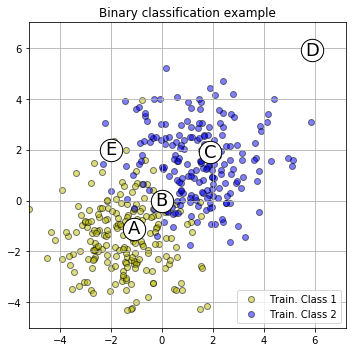

In [2]:
n_samples = 200 * 2
prior = [0.5, 0.5]
means = np.array([[-1.5, -1.5], [1.5, 1.5]])

model_c1 = multivariate_normal(mean=means[0], cov=np.array([[2,0], [0,2]]))
model_c2 = multivariate_normal(mean=means[1], cov=np.array([[2,0], [0,2]]))

np.random.seed(seed)
N = 200*2
X = np.concatenate((model_c1.rvs(int(n_samples * prior[0])),
                    model_c2.rvs(int(n_samples * prior[1]))))
y = np.concatenate((np.zeros(int(n_samples * prior[0])),
                    np.ones(int(n_samples * prior[1]))))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Binary classification example')
ax.scatter(X[y==0,0], X[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
ax.scatter(X[y==1,0], X[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
ax.grid(True)

x_predict = np.array([[-1.1,-1.1], [0,0], [1.9,1.9], [5.9,5.9], [-2,2]])
notes = ('A', 'B', 'C', 'D', 'E')
ax_scatter_question(ax, x_predict, notes)
plt.axis('equal')
        
ax.legend(loc='lower right')

x1_min, x1_max = (-5.0, 7.0)
x2_min, x2_max = (-5.0, 7.0)

ax.set_xlim([x1_min, x1_max])
ax.set_ylim([x2_min, x2_max])

# Train a classifier and a relative density estimator

The classifier needs to output probabilities, and the relative density estimator can be any function that i affine to an approximate of the density of the data with values restricted between 0 and 1

In [3]:
import fatf.utils.models as fatf_models
from fatf.accountability.models.background_check import BackgroundCheck
from fatf.accountability.models.background_check import update_posterior

from fatf.utils.data.density import GaussianRelativeDensityEstimator

# Train probabilistic classifier
#clf = fatf_models.KNN()
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(X, y)

# Train a relative density estimator
rde = GaussianRelativeDensityEstimator()
rde.fit(X)

# Create Background Check
bc = BackgroundCheck(clf, rde)

20-Jan-30 22:22:39 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.
/home/miquel/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(230400, 2)
480.0
length of unique values = 230400


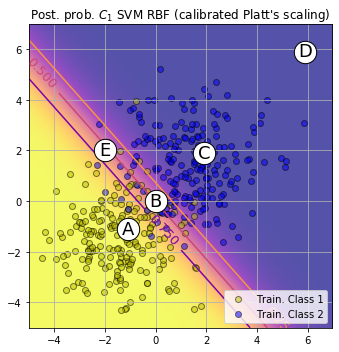

In [4]:
# Create a grid to visualize the predictions of our model
delta = 0.025
x1_grid = np.arange(x1_min, x1_max, delta)
x2_grid = np.arange(x2_min, x2_max, delta)
MX1, MX2 = np.meshgrid(x1_grid, x2_grid)
x_grid = np.asarray([MX1.flatten(),MX2.flatten()]).T

print(x_grid.shape)
print(np.sqrt(x_grid.shape[0]))

prediction = clf.predict_proba(x_grid)

Z = prediction[:,0].reshape(len(x2_grid), len(x1_grid))

fig = plt.figure(figsize=(5,5))
ax = plot_points_predictions(fig, X, y, Z, MX1, MX2, x_predict, notes, levels=[0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_title("Post. prob. $C_1$ SVM RBF (calibrated Platt's scaling)")

# Test Background Check
class_bg_posteriors = bc.predict_proba(X, mu0=1.0, mu1=0.0)

<Figure size 360x360 with 0 Axes>

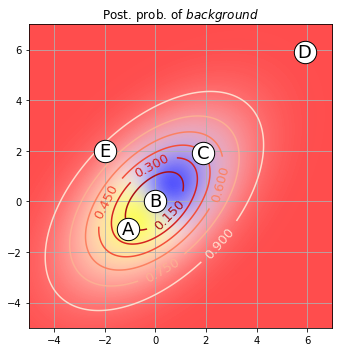

In [5]:
mu0 = 1.0
mu1 = 0.0

p_c1_c2_b_g_x = bc.predict_proba(x_grid, mu0=mu0, mu1=mu1)

fig = plt.figure(figsize=(5,5))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_title("Post. prob. of $background$")

extent=(x1_min, x1_max, x2_min, x2_max)
plot_probabilities(p_c1_c2_b_g_x, extent=(x1_min, x1_max, x2_min, x2_max))
#plot_points(fig, X, y, MX1, MX2, loc='lower right')
ax.grid(True)


CS = ax.contour(MX1, MX2, p_c1_c2_b_g_x[:, -1].reshape(MX1.shape), cmap=cm.Reds_r)
ax.clabel(CS, fontsize=13, inline=1)
ax_scatter_question(ax, x_predict, notes)

In [6]:
def plot_background_check(mu0, mu1, x, y):
    p_c1_c2_b_g_x = bc.predict_proba(x_grid, mu0=mu0, mu1=mu1)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Post. prob. of $background$")

    extent=(x1_min, x1_max, x2_min, x2_max)
    plot_probabilities(p_c1_c2_b_g_x, extent=(x1_min, x1_max, x2_min, x2_max))
    #plot_points(fig, X, y, MX1, MX2, loc='lower right')
    ax.grid(True)


    CS = ax.contour(MX1, MX2, p_c1_c2_b_g_x[:, -1].reshape(MX1.shape), cmap=cm.Reds_r)
    ax.clabel(CS, fontsize=13, inline=1)
    ax_scatter_question(ax, np.array([[x, y]]), ['?'])


# TODO: limit mu0 not to reach 0.0 inside background check
interact(plot_background_check, mu0=FloatSlider(value=0.5, min=1e-3, max=1, step=0.1, continuous_update=False),
                                mu1=FloatSlider(value=0.5, min=0.0, max=1, step=0.1, continuous_update=False),
                                x=IntSlider(min=-4, max=6, step=1, value=0, continuous_update=False),
                                y=IntSlider(min=-4, max=6, step=1, value=0, continuous_update=False))

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='mu0', max=1.0, min=0.001), …

<function __main__.plot_background_check(mu0, mu1, x, y)>

In [7]:
import numpy as np

rectangle = np.array([[x1_min, x2_min],[x1_min, x2_max],[x1_max,x2_max],[x1_max, x2_min]])
samples_x = X
samples_y = y

def plot_background_check(mu0, mu1, x, y, show_samples=False, show_background=False, example='Other'):
    if example == 'Confidence':
        mu0 = mu1 = 0.5
    elif example == 'Outlier':
        mu0 = 1
        mu1 = 0
    elif example == 'Cautious':
        mu0 = 0
        mu1 = 0.7
        
    if mu0 == 0:
        mu0 = 1e-7
    new_point_1, new_point_2 = get_two_intersections(rectangle, (means[0]+[x, y], means[1]+[x, y]))

    x_line = linspace_between_points(new_point_1, new_point_2)


    fig = plt.figure(figsize=(10,5))
    
    ax = fig.add_subplot(1,2,1)
        
    if show_samples:
        ax.scatter(samples_x[samples_y==0,0], samples_x[samples_y==0,1], c='y', alpha=0.5, label='Train. Class 1')
        ax.scatter(samples_x[samples_y==1,0], samples_x[samples_y==1,1], c='b', alpha=0.5, label='Train. Class 2')
        
    ax.set_title("Post. prob. of $background$")

    extent=(x1_min, x1_max, x2_min, x2_max)
    if show_background:
        p_c1_c2_b_g_x = bc.predict_proba(x_grid, mu0=mu0, mu1=mu1)
        plot_probabilities(p_c1_c2_b_g_x, extent=(x1_min, x1_max, x2_min, x2_max))
        CS = ax.contour(MX1, MX2, p_c1_c2_b_g_x[:, -1].reshape(MX1.shape), cmap=cm.Reds_r)
    else:
        p_c1_c2_g_f_x = clf.predict_proba(x_grid)
        plot_probabilities(p_c1_c2_g_f_x, extent=(x1_min, x1_max, x2_min, x2_max))
        CS = ax.contour(MX1, MX2, p_c1_c2_g_f_x[:, -1].reshape(MX1.shape), cmap=cm.plasma_r)
    ax.grid(True)

    ax.plot(x_line[:,0], x_line[:,1], 'k.')
    ax.clabel(CS, fontsize=13, inline=1)
    ax_scatter_question(ax, np.array([[x, y]]), ['?'])
    # TODO remove this limits and specify the correct x_line
    ax.set_xlim([x1_min, x1_max])
    ax.set_ylim([x2_min, x2_max])

        
    ax2 = fig.add_subplot(3,2,2)
    ax2.set_title('Post. prob. $C_1$ vs $C_2$ given $foreground$')
    p_c1_c2_b_g_x = clf.predict_proba(x_line)
    ax2.plot(p_c1_c2_b_g_x[:, 0], color='y', label='$p(C_1|f,x)$', linewidth=3)
    ax2.plot(p_c1_c2_b_g_x[:, 1], color='b', label='$p(C_2|f,x)$', linewidth=3)
    ax2.set_ylim([0,1])
    ax2.set_xlim([0, x_line.shape[0]-1])
    ax2.set_xticks([])
    ax2.legend(loc='upper right', labelspacing=0.1)
    
    q_f = bc.relative_density(x_line)
    q_b = q_f * mu1 + (1 - q_f) * mu0
    ax3 = fig.add_subplot(3,2,4)
    ax3.set_title('Relative densities for $foreground$ and $background$')
    # TODO fix the relative densities, as the foreground maximum is always 1, not the posterior.
    ax3.plot(q_f, color='g', label='$q_f(x)$', linewidth=3)
    ax3.plot(q_b, color='r', label='$q_b(x)$', linewidth=3)
    ax3.set_ylim([0,1])
    ax3.set_xlim([0, x_line.shape[0]-1])
    ax3.set_xticks([])
    ax3.legend(loc='upper right', labelspacing=0.1)
    
    p_c1_c2_b_g_x = bc.predict_proba(x_line, mu0=mu0, mu1=mu1)
    ax4 = fig.add_subplot(3,2,6)
    ax4.set_title('Post. prob. $C_1$ vs $C_2$ vs $background$')
    ax4.plot(p_c1_c2_b_g_x[:, 0], color='y', label='$p(C_1|f,x)$', linewidth=3)
    ax4.plot(p_c1_c2_b_g_x[:, 1], color='b', label='$p(C_2|f,x)$', linewidth=3)
    ax4.plot(p_c1_c2_b_g_x[:, 2], color='r', label='$p(b|x)$', linewidth=3)
    ax4.set_ylim([0,1])
    ax4.set_xlim([0, x_line.shape[0]-1])
    ax4.set_xticks([])
    ax4.legend(loc='upper right', labelspacing=0.1)

# TODO: limit mu0 not to reach 0.0 inside background check
interact(plot_background_check, example=ToggleButtons(
                                    options=['Confidence', 'Outlier', 'Cautious', 'Other'],
                                    description='Example'),
                                show_samples=Checkbox(value=True, description='Show samples'),
                                show_background=Checkbox(value=False, description='Show background'),
                                mu0=FloatSlider(value=0.5, min=0.0, max=1, step=0.1, continuous_update=False),
                                mu1=FloatSlider(value=0.5, min=0.0, max=1, step=0.1, continuous_update=False),
                                x=IntSlider(min=-4, max=6, step=2, value=0, continuous_update=False),
                                y=IntSlider(min=-4, max=6, step=2, value=0, continuous_update=False),                                        
        )

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='mu0', max=1.0), FloatSlider…

<function __main__.plot_background_check(mu0, mu1, x, y, show_samples=False, show_background=False, example='Other')>

# Examples

- Classification with confidence: mu0 = mu1 = 0.5 
- Outlier detection: mu0 = 1.0, mu1 = 0.0
- Cautios classification: mu0 = 0.0, mu1 = 0.75